In [1]:
import os

import torch
# import torchvision
from torchvision.transforms import v2

# from torch import nn
# from torchsummary import summary

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm

%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<Figure size 500x500 with 0 Axes>

In [2]:
test_prop = 0.2
val_prop = 0.1

batch_size = 64

# img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-fft'

In [3]:
# Creating the datasets

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.Normalize(mean=[0, 150], std=[67, 100]),
    v2.Normalize(mean=[0, 150], std=[100, 100]),

    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])

target_transform = v2.Compose([
    v2.ToTensor(),
    # v2.Normalize(mean=[0, 150], std=[67, 100]),
    v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])


train_labeled_data = CloudDetectionTrain(
    transform=transform
)

test_labeled_data = CloudDetectionTrain(
    target_transform=target_transform
)


In [4]:
d0 = np.random.randn(32,32)
d1 = np.random.randn(32,32)
z = np.zeros((32,32, 2))
z[..., 0] = d0
z[..., 1] = d1
transform(z)[0].shape

torch.Size([32, 32])

In [5]:
pano_df = train_labeled_data.dataset_manager.main_dfs['pano']
feature_df = train_labeled_data.dataset_manager.main_dfs['feature']
feature_merged_df = feature_df.reset_index().merge(pano_df, on = 'pano_uid').set_index('index')
dsl_merged = feature_merged_df.merge(train_labeled_data.dsl_df, on = 'feature_uid').reset_index()

def data_split(test_prop, val_prop, batch_id, boundary_prop=0.3):
    assert 0 <= test_prop <= 1, 0 <= val_prop <= 1
    batch_data = dsl_merged[dsl_merged['batch_id_x'] == batch_id].sort_values(by = 'frame_unix_t')
    
    test_split = int(len(batch_data) * test_prop)
    ntrain = len(batch_data) - test_split
    val_split = int(ntrain * val_prop)
    boundary_cnt = int((len(batch_data) - val_split) * boundary_prop)
    
    test_idx = batch_data[:test_split].index.values
    val_idx = batch_data[test_split: test_split + val_split].index.values
    train_idx = batch_data[test_split + val_split + boundary_cnt:].index.values
    
    return test_idx, val_idx, train_idx

def get_test_val_train_indices(test_prop, val_prop):
    test_indices = np.array([], dtype=np.int64)
    val_indices = np.array([], dtype=np.int64)
    train_indices = np.array([], dtype=np.int64)

    for batch_id in pano_df['batch_id'].unique():
        test_idx, val_idx, train_idx = data_split(test_prop, val_prop, batch_id)
        test_indices = np.concatenate((test_indices, test_idx))
        val_indices = np.concatenate((val_indices, val_idx))
        train_indices = np.concatenate((train_indices, train_idx))
    return test_indices, val_indices, train_indices

In [6]:
dataset_size = len(dsl_merged)


# dataset_indices = np.arange(dataset_size)

# np.random.shuffle(dataset_indices)

# # Test / Train split
# test_split_index = int(np.floor(test_prop * dataset_size))
# trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]

# # Train / Val split
# trainset_size = len(trainset_indices)
# val_split_index = int(np.floor(val_prop * trainset_size))
# train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]


test_idx, val_idx, train_idx = get_test_val_train_indices(test_prop, val_prop)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop = {100 * len(train_idx) / dataset_size:.2f}%\n'
      f'val_prop = {100 * len(val_idx) / dataset_size:.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]
def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    num_clear = len(filtered_data.loc[filtered_data['label'] == 'clear_night_sky'])
    num_cloudy = len(filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy'])
    print(f'Percent cloudy (in {name}) = {100 *num_cloudy / len(filtered_data):.3f}% ({num_cloudy} / {len(filtered_data)})')

print_class_dist(dsl_merged, test_idx, 'train')
print_class_dist(dsl_merged, val_idx, 'val')
print_class_dist(dsl_merged, train_idx, 'train')
print_class_dist(dsl_merged, dsl_merged.index, 'overall')

test_prop = 19.96%
train_prop = 44.52%
val_prop = 7.94%
Percent cloudy (in train) = 53.531% (940 / 1756)
Percent cloudy (in val) = 55.365% (387 / 699)
Percent cloudy (in train) = 55.323% (2167 / 3917)
Percent cloudy (in overall) = 55.052% (4844 / 8799)


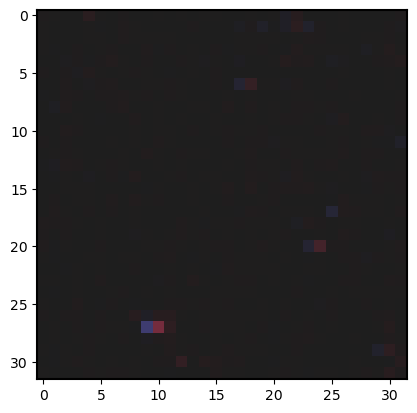

In [7]:
rn = np.random.choice(len(train_labeled_data), size=30, replace=False)
train_labeled_data.dataset_manager.main_dfs['feature']['batch_id'].unique()
images = [train_labeled_data[i][0][0] for i in rn]
# plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)));
import time
from IPython import display

try:
    for j in range(len(train_labeled_data)):
        images = [train_labeled_data[i][0][0] for i in rn]
        for i in images:
            # plt.figure(figsize=(20,10))
            plt.imshow(i, vmin=-2, vmax=2, cmap='icefire')
            plt.show()
            plt.close()
            time.sleep(.01)
            display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()

In [24]:
# Code for finding the intersection between two arrays
arr1 = np.array(
    [[1,2,3,4,5],
     [1,2,3,4,5],
     [1,2,3,4,5]
    ]
)
arr2 = np.array(
    [[1,2,3,40,50],
    [1,2,3,40,50],
    [1,2,3,40,50]]
)
np.stack((arr1, arr2)).shape

(2, 3, 5)

In [25]:
# Use that code here:
test = set(test_idx)
train = set(train_idx)
val = set(val_idx)
print(test.intersection(train))  # empty set, showing there is no overlap between test and train indices.
print(test.intersection(val))    # empty set, showing there is no overlap between test and val indices.

set()
set()


In [21]:
# Training config

learning_rate = 0.001
# momentum=0.9

model = CloudDetection()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=20, gamma=0.9, do_summary=True,
    # img_type=img_type
);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,260
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  252
|    └─Dropout2d: 2-4                    --
|    └─Conv2d: 2-5                       71,568
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  252
|    └─Dropout2d: 2-8                    --
|    └─MaxPool2d: 2-9                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-10                      227,000
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 400
|    └─Dropout2d: 2-13                   --
|    └─Conv2d: 2-14                      360,200
|    └─ReLU: 2-15                        --
|    └─BatchNorm2d: 2-16                 400
|    └─Dropout2d: 2-17                   --
|    └─MaxPool2d: 2-18                   --
├─Flatten: 1-3                           --
├─Sequ

In [ ]:
trainer.train()



Epoch 1


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.4492,  acc = 601/699 (85.98%) 
      Train: 	loss = 0.4554,  acc = 3314/3917 (84.61%)


Epoch 2


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.4345,  acc = 598/699 (85.55%) 
      Train: 	loss = 0.4396,  acc = 3311/3917 (84.53%)


Epoch 3


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.4838,  acc = 641/699 (91.70%) 
      Train: 	loss = 0.4895,  acc = 3617/3917 (92.34%)


Epoch 4


  0%|          | 0/62 [00:00<?, ?batches/s]

       Val: 	loss = 0.4494,  acc = 615/699 (87.98%) 
      Train: 	loss = 0.4592,  acc = 3371/3917 (86.06%)


Epoch 5


  0%|          | 0/62 [00:00<?, ?batches/s]

  0%|          | 0/28 [00:00<?, ?batches/s]

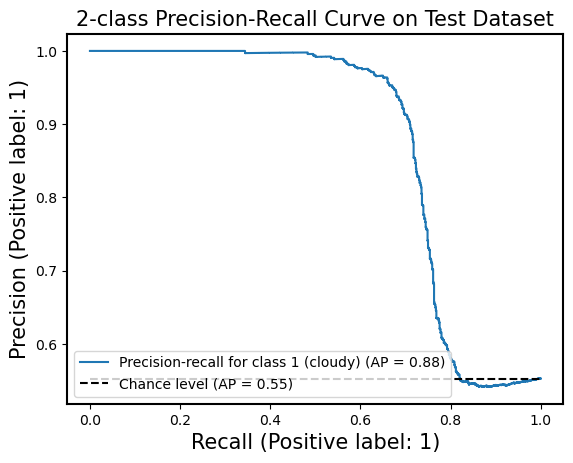

Test: 	loss = 0.3568,  acc = 1685/1756 (95.96%)


In [15]:
tester = Tester(model, loss_fn, test_loader)
tester.eval()

In [ ]:
model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth'))
tester = Tester(model, loss_fn, test_loader)
tester.eval()